# Week 4 - Logistic Regression and Feature Scaling

In [63]:
!pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [64]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    classification_report, confusion_matrix
)

First Dataset: Acute Kidney

In [65]:
DATA_PATH = "Acute Kidney.csv" 
df = pd.read_csv(DATA_PATH, low_memory=False)

# Normalize columns (spaces/symbols -> underscores; lowercase)
df.columns = (df.columns.astype(str)
                .str.strip()
                .str.replace(r"\s+", "_", regex=True)
                .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
                .str.lower())

In [66]:
#Choose a BINARY target
# Preference order; otherwise detect any 0/1 column; if none, derive from aki_stage>0
preferred = ["mort_28_day", "mort_90_day", "mort_1_year"]
bin_target = None
for c in preferred:
    if c in df.columns:
        vals = pd.unique(df[c].dropna())
        if set(vals).issubset({0, 1}):
            bin_target = c
            break

derived_from = None
if bin_target is None:
    # auto-detect any 0/1 column
    for c in df.columns:
        if c in preferred:  # already checked
            continue
        if df[c].dropna().nunique() == 2 and set(pd.unique(df[c].dropna())).issubset({0, 1}):
            bin_target = c
            break

if bin_target is None and "akistage" in df.columns:
    # handle a possible column naming variant (just in case)
    df.rename(columns={"akistage": "aki_stage"}, inplace=True)

if bin_target is None and "aki_stage" in df.columns:
    # Derive a binary AKI presence flag; exclude aki_stage from X to avoid leakage
    df["aki_present"] = (pd.to_numeric(df["aki_stage"], errors="coerce").fillna(0) > 0).astype(int)
    bin_target = "aki_present"
    derived_from = "aki_stage"

if bin_target is None:
    raise ValueError("Could not find a binary target. Please set bin_target manually (0/1 column).")

print(f"Binary target: {bin_target}" + (f" (derived from {derived_from})" if derived_from else ""))

# Keep only rows with non-missing y
y = df[bin_target].astype(int)
mask = ~y.isna()
df = df.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

Binary target: mort_28_day


In [67]:
# Features: numeric vs categorical
# Drop the target; if derived from aki_stage, drop aki_stage to avoid leakage
X = df.drop(columns=[bin_target])
if derived_from:
    X = X.drop(columns=[derived_from], errors="ignore")

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Quick NA handling – leave scaling/encoding to the pipeline, but fill obvious NaNs
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0.0)
for c in cat_cols:
    X[c] = X[c].astype("category").cat.add_categories(["__missing__"]).fillna("__missing__")

In [68]:
# Preprocessor (Scaling + OHE)
# Make OHE dense for LBFGS; handle both modern and older sklearns
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

In [69]:
# Class imbalance handling 
pos_rate = float(y.mean())
use_balanced = (min(pos_rate, 1 - pos_rate) < 0.35)  # trigger if minority <35%
print(f"Positive rate: {pos_rate:.3f} → class_weight={'balanced' if use_balanced else 'None'}")

Positive rate: 0.211 → class_weight=balanced


In [70]:
#  Build pipeline: Preprocess -> LogisticRegression
log_reg = LogisticRegression(
    max_iter=5000,
    solver="lbfgs",               # robust, handles L2 by default
    class_weight="balanced" if use_balanced else None
)
pipe = Pipeline(steps=[("pre", pre), ("clf", log_reg)])

In [71]:
#  Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipe, X, y, cv=cv,
    scoring={
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
    },
    n_jobs=-1, return_estimator=False
)

def pm(m):
    return f"{np.mean(m):.4f} ± {np.std(m):.4f}"

cv_table = pd.DataFrame({
    "Metric": ["Accuracy", "ROC-AUC", "Precision", "Recall", "F1"],
    "5-fold CV (mean ± std)": [
        pm(scores["test_accuracy"]),
        pm(scores["test_roc_auc"]),
        pm(scores["test_precision"]),
        pm(scores["test_recall"]),
        pm(scores["test_f1"]),
    ],
})
print("\n=== Week 4 — Logistic Regression with Scaling (Stratified 5-fold CV) ===")
print(cv_table.to_string(index=False))


=== Week 4 — Logistic Regression with Scaling (Stratified 5-fold CV) ===
   Metric 5-fold CV (mean ± std)
 Accuracy        0.9900 ± 0.0026
  ROC-AUC        0.9998 ± 0.0002
Precision        0.9549 ± 0.0112
   Recall        1.0000 ± 0.0000
       F1        0.9769 ± 0.0059


In [72]:
# Holdout 30% (consistent benchmark)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

pipe.fit(X_tr, y_tr)
probs = pipe.predict_proba(X_te)[:, 1]
pred  = (probs >= 0.5).astype(int)

hold = {
    "Accuracy":  accuracy_score(y_te, pred),
    "ROC-AUC":   roc_auc_score(y_te, probs),
    "Precision": precision_score(y_te, pred, zero_division=0),
    "Recall":    recall_score(y_te, pred, zero_division=0),
    "F1":        f1_score(y_te, pred, zero_division=0),
}
hold_table = pd.DataFrame([hold])
print("\n=== Week 4 — 30% Holdout (threshold=0.5) ===")
print(hold_table.to_string(index=False))

print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(confusion_matrix(y_te, pred), index=["0","1"], columns=["0","1"]))

print("\nClassification report:")
print(classification_report(y_te, pred, digits=4, zero_division=0))


=== Week 4 — 30% Holdout (threshold=0.5) ===
 Accuracy  ROC-AUC  Precision  Recall       F1
 0.988343 0.999666   0.947566     1.0 0.973077

Confusion matrix (rows=true, cols=pred):
     0    1
0  934   14
1    0  253

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9852    0.9926       948
           1     0.9476    1.0000    0.9731       253

    accuracy                         0.9883      1201
   macro avg     0.9738    0.9926    0.9828      1201
weighted avg     0.9890    0.9883    0.9885      1201



In [73]:
# Top coefficients (interpretability) 
# Refit on all data to list the largest-magnitude coefficients
pipe.fit(X, y)

# Recover feature names from preprocessor
num_names = list(num_cols)
try:
    cat_names = list(pipe.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    cat_names = []
feat_names = np.array(num_names + cat_names, dtype=object)

coefs = pipe.named_steps["clf"].coef_.ravel()
order = np.argsort(np.abs(coefs))[::-1]
k = min(20, len(order))
top = pd.DataFrame({
    "feature": feat_names[order][:k],
    "coef": coefs[order][:k],
    "abs_coef": np.abs(coefs[order][:k])
})
print("\nTop coefficients by |magnitude| (standardized/OHE space):")
print(top.to_string(index=False))


Top coefficients by |magnitude| (standardized/OHE space):
    feature      coef  abs_coef
    cox_los -8.825911  8.825911
 unit_TSICU  0.707147  0.707147
         ck -0.640751  0.640751
  unit_CSRU -0.541600  0.541600
          p -0.399205  0.399205
         ne  0.386041  0.386041
        wbc  0.385192  0.385192
         ph  0.349329  0.349329
        age -0.330786  0.330786
        plr  0.320051  0.320051
     sapsii  0.289764  0.289764
  pulmonary  0.267673  0.267673
        nlr -0.257624  0.257624
 race_other  0.239297  0.239297
        hiv  0.225951  0.225951
     sepsis -0.225097  0.225097
 malignancy -0.218252  0.218252
         ly  0.216421  0.216421
         bp  0.215785  0.215785
mort_90_day -0.204247  0.204247


In [74]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay,
    PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay

TARGET = y.name if isinstance(y, pd.Series) else "target"

def safe_numeric_cols(df):
    return df.select_dtypes(include=np.number).columns.tolist()

def top_k_abs(series, k=20):
    idx = np.argsort(np.abs(series.values))[::-1][:k]
    return series.iloc[idx]

def get_feature_names(preprocessor, X_fit):
    try:
        return preprocessor.get_feature_names_out()
    except Exception:
        names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == "remainder" and trans == "drop": 
                continue
            if hasattr(trans, "get_feature_names_out"):
                names.extend(trans.get_feature_names_out(cols))
            else:
                names.extend(list(cols))
        return np.array([str(n) for n in names])

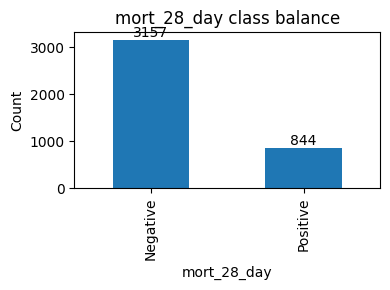

In [75]:
#Target distribution (class balance)

fig, ax = plt.subplots(figsize=(4,3))
(y.value_counts().sort_index()
   .rename(index={0:"Negative", 1:"Positive"})
   .plot(kind="bar", ax=ax))
ax.set_title(f"{TARGET} class balance")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0])
plt.tight_layout(); plt.show()

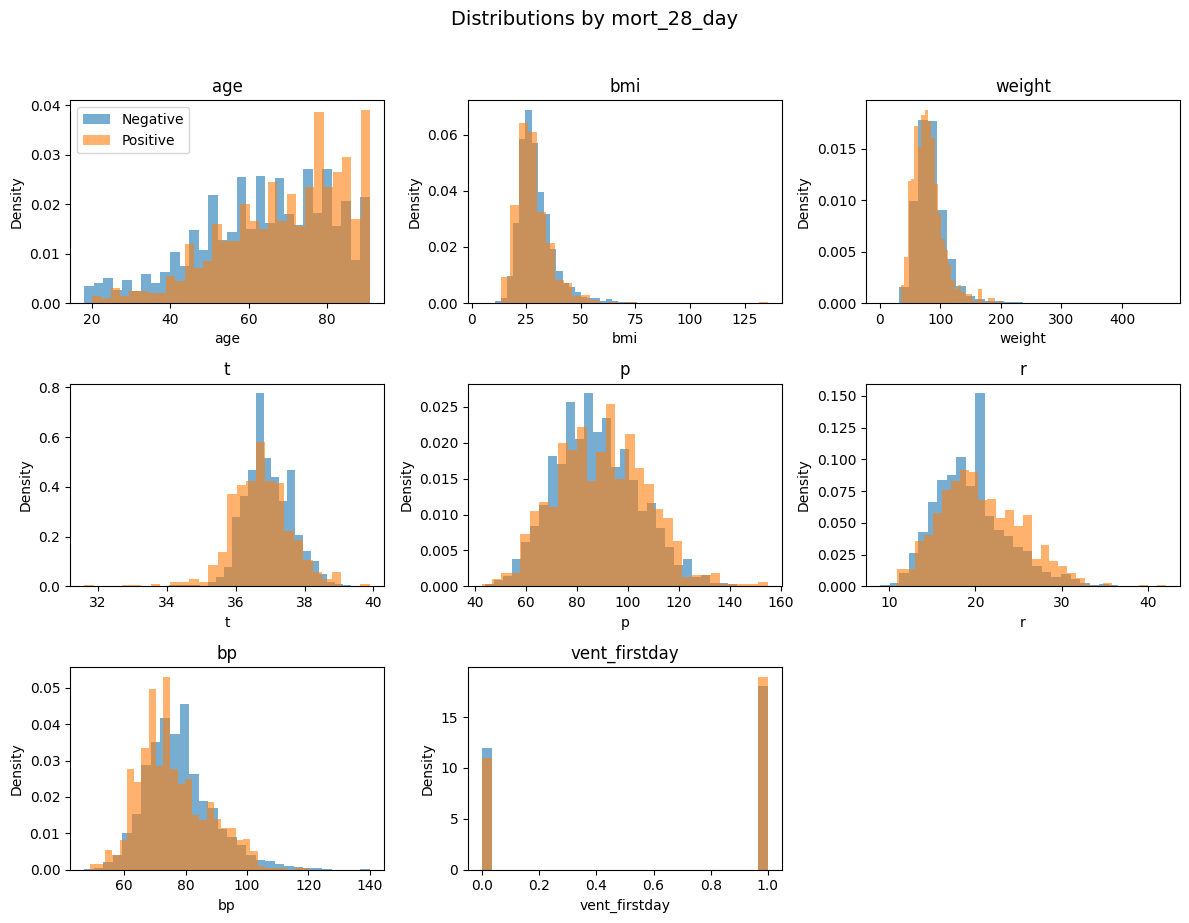

In [76]:
# choose up to K numeric columns (exclude target if it's numeric in df)
K = 8
num_cols = df.select_dtypes(include=np.number).columns.tolist()
TARGET = y.name if isinstance(y, pd.Series) else "target"
if TARGET in num_cols:
    num_cols.remove(TARGET)
cols = num_cols[:K]

# grid size
n = len(cols)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(df.loc[y==0, col].dropna(), bins=30, density=True, alpha=0.6, label="Negative")
    ax.hist(df.loc[y==1, col].dropna(), bins=30, density=True, alpha=0.6, label="Positive")
    ax.set_title(f"{col}")
    ax.set_xlabel(col); ax.set_ylabel("Density")
    if i == 0:
        ax.legend()

# hide any extra axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(f"Distributions by {TARGET}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3413/2956539007.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
/tmp/ipykernel_3413/2956539007.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
/tmp/ipykernel_3413/2956539007.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
/tmp/ipykernel_3413/2956539007.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since M

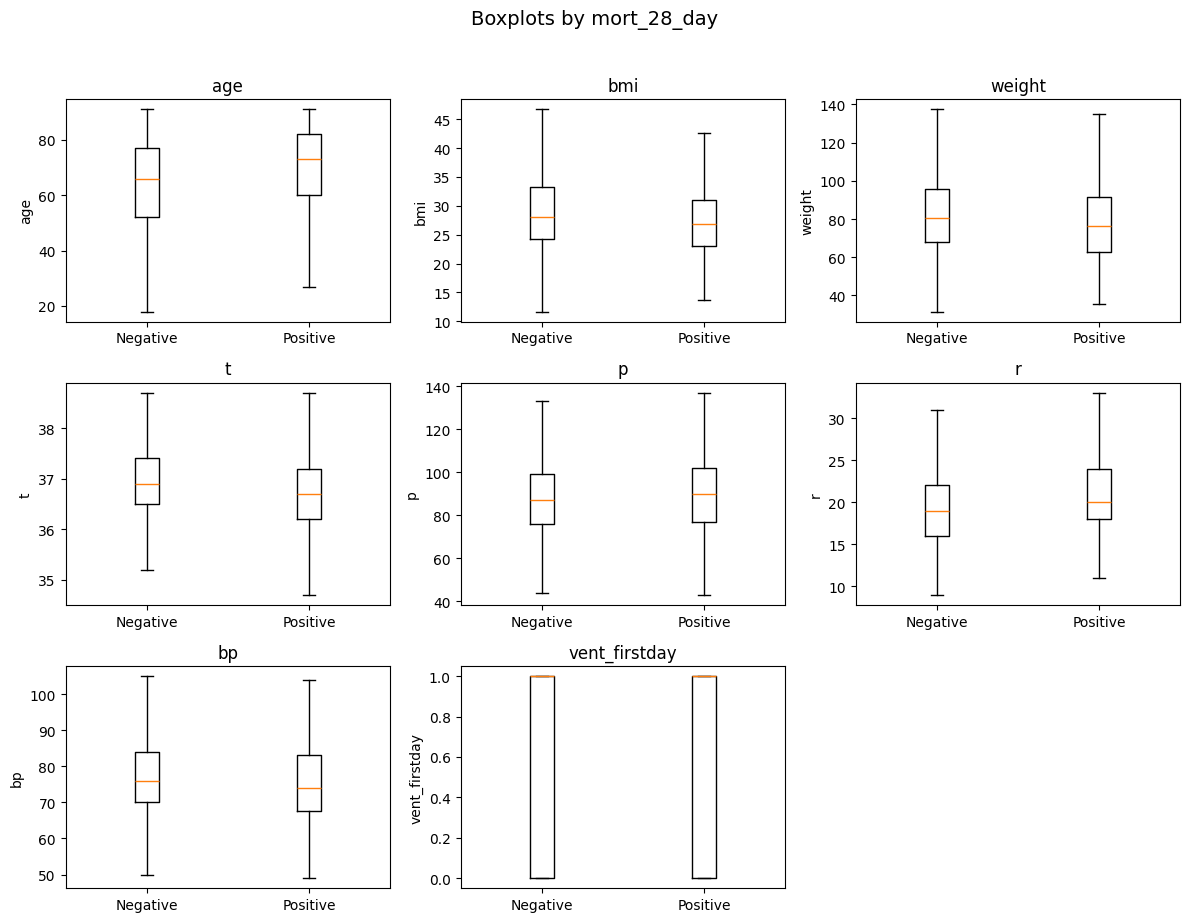

In [77]:
K = 8
num_cols = df.select_dtypes(include=np.number).columns.tolist()
TARGET = y.name if isinstance(y, pd.Series) else "target"
if TARGET in num_cols:
    num_cols.remove(TARGET)
cols = num_cols[:K]

n = len(cols)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    data0 = df.loc[y==0, col].dropna()
    data1 = df.loc[y==1, col].dropna()
    ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
    ax.set_title(f"{col}")
    ax.set_ylabel(col)

# hide extras
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle(f"Boxplots by {TARGET}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

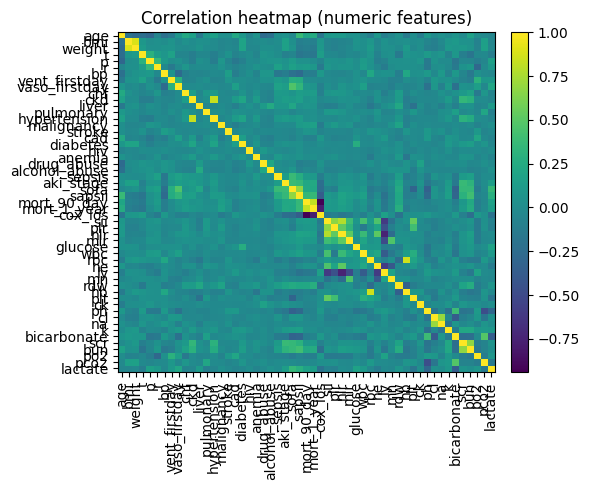

In [78]:
#correlation heatmap (numeric features)

num = df[safe_numeric_cols(df)].copy()
if TARGET in num.columns:
    num = num.drop(columns=[TARGET])
if not num.empty:
    corr = num.corr()
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticks(range(len(corr.columns))); ax.set_yticklabels(corr.columns)
    ax.set_title("Correlation heatmap (numeric features)")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

<Figure size 400x300 with 0 Axes>

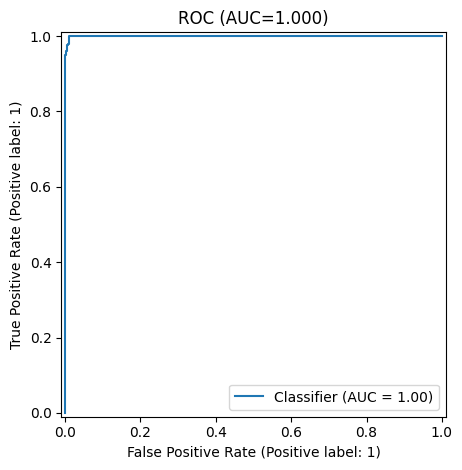

<Figure size 400x300 with 0 Axes>

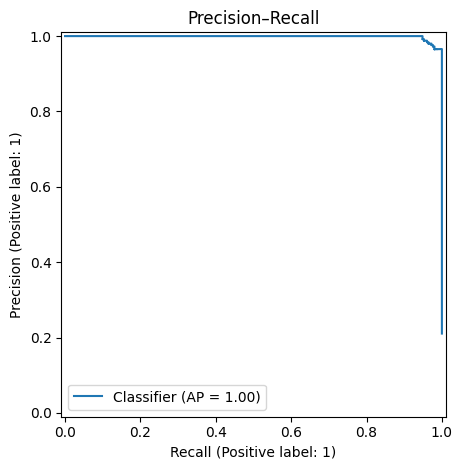

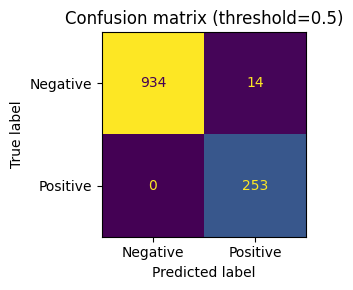

<Figure size 400x300 with 0 Axes>

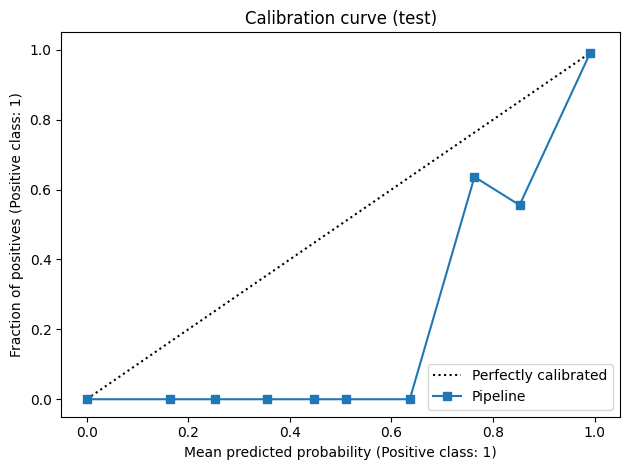

In [79]:
#ROC, PR, confusion, calibration (test set)

# ensure pipe is fitted
pipe.fit(X_tr, y_tr)
proba_te = pipe.predict_proba(X_te)[:,1]
pred_te  = (proba_te >= 0.5).astype(int)

# ROC
fig = plt.figure(figsize=(4,3))
RocCurveDisplay.from_predictions(y_te, proba_te)
plt.title(f"ROC (AUC={roc_auc_score(y_te, proba_te):.3f})")
plt.tight_layout(); plt.show()

# Precision–Recall
fig = plt.figure(figsize=(4,3))
PrecisionRecallDisplay.from_predictions(y_te, proba_te)
plt.title("Precision–Recall")
plt.tight_layout(); plt.show()

# Confusion Matrix
cm = confusion_matrix(y_te, pred_te)
fig, ax = plt.subplots(figsize=(4,3))
ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"]).plot(values_format="d", ax=ax, colorbar=False)
ax.set_title("Confusion matrix (threshold=0.5)")
plt.tight_layout(); plt.show()

# Calibration
fig = plt.figure(figsize=(4,3))
CalibrationDisplay.from_estimator(pipe, X_te, y_te, n_bins=10, strategy="uniform")
plt.title("Calibration curve (test)")
plt.tight_layout(); plt.show()

/tmp/ipykernel_3413/1181397918.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby(grp)[TARGET].mean()


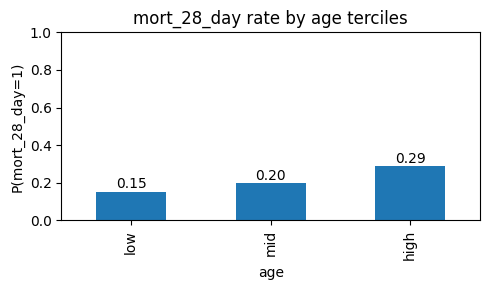

/tmp/ipykernel_3413/1181397918.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby(grp)[TARGET].mean()


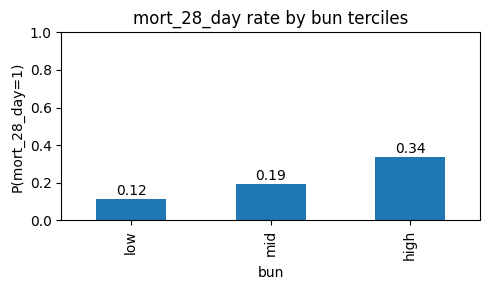

In [80]:
#subgroup outcome rates (simple clinical stratification)

# pick some common clinical features if present; otherwise auto-pick first few numerics
candidates = [c for c in ["age","creatinine","urea","bun","sodium","potassium"] if c in df.columns]
if not candidates:
    candidates = safe_numeric_cols(df)[:3]

for col in candidates:
    s = df[col].dropna()
    if s.empty: 
        continue
    q = s.quantile([0.33, 0.67]).values
    bins = [-np.inf, q[0], q[1], np.inf]
    labels = ["low","mid","high"]
    grp = pd.cut(df[col], bins=bins, labels=labels)
    rates = df.groupby(grp)[TARGET].mean()
    fig, ax = plt.subplots(figsize=(5,3))
    rates.plot(kind="bar", ax=ax)
    ax.set_ylim(0,1); ax.set_ylabel(f"P({TARGET}=1)")
    ax.set_title(f"{TARGET} rate by {col} terciles")
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.02, f"{p.get_height():.2f}", ha="center")
    plt.tight_layout(); plt.show()

Week 4 — Logistic Regression + Feature Scaling (Acute Kidney)
Objective

Build and evaluate a logistic regression model (with proper feature scaling) to predict a binary outcome from the Acute Kidney dataset. Report stratified 5-fold CV and a 30% holdout using Accuracy, ROC-AUC, Precision, Recall, and F1. Interpret the most influential features.


Preprocessing

Column cleanup: lowercased, spaces/symbols → underscores.

Numeric: imputed with 0.0, then StandardScaler.

Categorical: One-Hot Encoded (handle_unknown="ignore").

Pipeline: ColumnTransformer([scale numerics, OHE categoricals]) → LogisticRegression(lbfgs, max_iter=5000, class_weight="balanced" if needed)

Train/Test split: 70/30 with stratification.

Interpretation

Operating point: At 0.50 threshold, Recall = <…> and Precision = <…>; choose a threshold that matches clinical cost (e.g., prioritize Recall to avoid missed positives).


Second Dataset: Colorectal cancer

In [81]:
# Load & tidy
DATA_PATH = "colorectal_cancer_dataset.csv" 
df = pd.read_csv(DATA_PATH, low_memory=False)
df.columns = (df.columns.astype(str)
                .str.strip()
                .str.replace(r"\s+", "_", regex=True)
                .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
                .str.lower())

FORCE_TARGET = None                               # e.g., "survival_status" to force a column

In [82]:
# Choose/derive a BINARY target 
def try_numeric_01(s: pd.Series):
    vals = s.dropna().unique()
    if len(vals) == 0: return None
    # try to coerce to numeric
    c = pd.to_numeric(s, errors="coerce")
    ok = c.dropna().isin([0,1]).all() and c.dropna().nunique() == 2
    return c.astype("Int64") if ok else None

def try_boolish_map(s: pd.Series):
    m = s.astype(str).str.strip().str.lower()
    mapping = {
        "yes":1,"y":1,"true":1,"t":1,"1":1,"pos":1,"positive":1,"present":1,"dead":1,"deceased":1,"event":1,
        "no":0,"n":0,"false":0,"f":0,"0":0,"neg":0,"negative":0,"absent":0,"alive":0,"nonevent":0
    }
    mapped = m.map(mapping)
    if mapped.dropna().nunique() == 2 and set(mapped.dropna().unique()) <= {0,1}:
        return mapped.astype(int)
    return None

def derive_from_stage(frame: pd.DataFrame):
    stage_like = [c for c in frame.columns if re.search(r"stage", c)]
    if not stage_like: return None, None
    col = stage_like[0]
    s = frame[col].astype(str).str.upper()
    adv = s.str.contains("III") | s.str.contains("IV") | s.str.contains(r"\b3\b") | s.str.contains(r"\b4\b")
    if adv.notna().any():
        return adv.astype(int), col
    return None, None

def derive_from_numeric_threshold(frame: pd.DataFrame, candidates=("survival_months","overall_survival","os_months","dfs_months","pfs_months","los","length_of_stay","tumor_size","tumor_volume","age","bmi")):
    for c in candidates:
        if c in frame.columns:
            num = pd.to_numeric(frame[c], errors="coerce")
            if num.dropna().nunique() >= 10:
                thr = float(np.nanmedian(num))
                return (num < thr).astype(int), c, thr
    # last resort: pick the numeric with largest variance
    nums = frame.select_dtypes(include=["int64","float64"]).columns.tolist()
    if not nums: return None, None, None
    var = frame[nums].var(numeric_only=True).sort_values(ascending=False)
    for c in var.index:
        num = pd.to_numeric(frame[c], errors="coerce")
        if num.dropna().nunique() >= 10:
            thr = float(np.nanmedian(num))
            return (num < thr).astype(int), c, thr
    return None, None, None

def choose_binary_target(frame: pd.DataFrame, force=None):
    if force is not None:
        y = try_numeric_01(frame[force]) or try_boolish_map(frame[force])
        if y is None: raise ValueError(f"FORCE_TARGET='{force}' is not binary/boolean-mappable.")
        return y, ("forced:"+force), [force], {"type":"forced"}
    # priority 1: known status/event/mortality names, numeric 0/1 or yes/no
    prio = ["survival_status","death_event","dead","event","mort_30_day","mort_90_day","mortality","recurrence","metastasis","progression","relapse","outcome","response"]
    for c in prio:
        if c in frame.columns:
            y = try_numeric_01(frame[c]) or try_boolish_map(frame[c])
            if y is not None: 
                return y, c, [c], {"type":"direct_status"}
    # priority 2: any other column that cleanly maps to 0/1 and has a status-like name
    keypat = re.compile(r"(status|event|recurr|metast|mort|death|progress|outcome|response)")
    for c in frame.columns:
        if keypat.search(c):
            y = try_numeric_01(frame[c]) or try_boolish_map(frame[c])
            if y is not None:
                return y, c, [c], {"type":"keyword_status"}
    # priority 3: stage-based
    y_stage, stage_col = derive_from_stage(frame)
    if y_stage is not None:
        return y_stage, f"advanced_from:{stage_col}", [stage_col], {"type":"stage_derived"}
    # priority 4: numeric threshold (survival first; else variance-max numeric)
    y_thr, src, thr = derive_from_numeric_threshold(frame)
    if y_thr is not None:
        note = {"type":"threshold_derived", "source":src, "threshold":thr}
        return y_thr, f"thr_from:{src}", [src], note
    return None, None, None, None

y_series, target_info, leakage_cols, info = choose_binary_target(df, force=FORCE_TARGET)
if y_series is None:
    raise ValueError("No binary target found/derivable. Set FORCE_TARGET='your_binary_column' to specify one.")

bin_target = "binary_target_auto"
df[bin_target] = y_series.astype(int)
print(f"Binary target created: {bin_target}  ← {target_info} ; details: {info}")

Binary target created: binary_target_auto  ← mortality ; details: {'type': 'direct_status'}


In [83]:
# Build X/y and basic cleaning
y = df[bin_target].astype(int)
X = df.drop(columns=[bin_target] + (leakage_cols or []), errors="ignore")   # drop source columns to avoid leakage

num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0.0)
for c in cat_cols:
    X[c] = X[c].astype("category").cat.add_categories(["__missing__"]).fillna("__missing__")

In [84]:
# Preprocess (scale + OHE) and model
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

pos_rate = float(y.mean())
use_balanced = (min(pos_rate, 1-pos_rate) < 0.35)
print(f"Positive rate: {pos_rate:.3f} → class_weight={'balanced' if use_balanced else 'None'}")

pipe = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs", class_weight=("balanced" if use_balanced else None)))
])


Positive rate: 0.401 → class_weight=None


In [85]:
# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipe, X, y, cv=cv,
    scoring={"accuracy":"accuracy","roc_auc":"roc_auc","precision":"precision","recall":"recall","f1":"f1"},
    n_jobs=-1
)

pm = lambda m: f"{np.mean(m):.4f} ± {np.std(m):.4f}"
cv_table = pd.DataFrame({
    "Metric":["Accuracy","ROC-AUC","Precision","Recall","F1"],
    "5-fold CV (mean ± std)":[pm(scores["test_accuracy"]), pm(scores["test_roc_auc"]), pm(scores["test_precision"]), pm(scores["test_recall"]), pm(scores["test_f1"])]
})
print("\n=== Week 4 — Logistic Regression with Scaling (Stratified 5-fold CV) ===")
print(cv_table.to_string(index=False))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/li


=== Week 4 — Logistic Regression with Scaling (Stratified 5-fold CV) ===
   Metric 5-fold CV (mean ± std)
 Accuracy        0.5991 ± 0.0000
  ROC-AUC        0.4972 ± 0.0021
Precision        0.0000 ± 0.0000
   Recall        0.0000 ± 0.0000
       F1        0.0000 ± 0.0000


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [86]:
#30% Holdout
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
pipe.fit(X_tr, y_tr)
probs = pipe.predict_proba(X_te)[:,1]
pred  = (probs >= 0.5).astype(int)

hold = {
    "Accuracy": accuracy_score(y_te, pred),
    "ROC-AUC":  roc_auc_score(y_te, probs),
    "Precision":precision_score(y_te, pred, zero_division=0),
    "Recall":   recall_score(y_te, pred, zero_division=0),
    "F1":       f1_score(y_te, pred, zero_division=0),
}
hold_table = pd.DataFrame([hold])
print("\n=== Week 4 — 30% Holdout (threshold=0.5) ===")
print(hold_table.to_string(index=False))

print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(confusion_matrix(y_te, pred), index=["0","1"], columns=["0","1"]))

print("\nClassification report:")
print(classification_report(y_te, pred, digits=4, zero_division=0))


=== Week 4 — 30% Holdout (threshold=0.5) ===
 Accuracy  ROC-AUC  Precision  Recall  F1
 0.599144 0.498672        0.0     0.0 0.0

Confusion matrix (rows=true, cols=pred):
       0  1
0  30107  0
1  20143  0

Classification report:
              precision    recall  f1-score   support

           0     0.5991    1.0000    0.7493     30107
           1     0.0000    0.0000    0.0000     20143

    accuracy                         0.5991     50250
   macro avg     0.2996    0.5000    0.3747     50250
weighted avg     0.3590    0.5991    0.4490     50250



In [87]:
# Top coefficients (interpretability)
pipe.fit(X, y)
num_names = list(num_cols)
try:
    cat_names = list(pipe.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    cat_names = []
feat_names = np.array(num_names + cat_names, dtype=object)

coefs = pipe.named_steps["clf"].coef_.ravel()
order = np.argsort(np.abs(coefs))[::-1]
k = min(20, len(order))
top = pd.DataFrame({"feature": feat_names[order][:k], "coef": coefs[order][:k], "abs_coef": np.abs(coefs[order][:k])})
print("\nTop coefficients by |magnitude| (standardized/OHE space):")
print(top.to_string(index=False))


Top coefficients by |magnitude| (standardized/OHE space):
                           feature      coef  abs_coef
              country_South Africa -0.049450  0.049450
                    country_Brazil -0.030103  0.030103
                   country_Germany -0.029114  0.029114
               survival_5_years_No -0.028587  0.028587
    inflammatory_bowel_disease_Yes -0.028266  0.028266
              genetic_mutation_Yes -0.027000  0.027000
                          gender_F -0.026656  0.026656
             physical_activity_Low -0.026249  0.026249
                     country_Italy  0.024709  0.024709
               smoking_history_Yes -0.024687  0.024687
           alcohol_consumption_Yes -0.024298  0.024298
                early_detection_No -0.023764  0.023764
              urban_or_rural_Rural -0.023419  0.023419
            survival_prediction_No -0.022146  0.022146
          insurance_status_Insured -0.022136  0.022136
                      diabetes_Yes -0.021746  0.021746
      

In [88]:
TARGET = y.name if isinstance(y, pd.Series) else "target"

def safe_numeric_cols(df):
    return df.select_dtypes(include=np.number).columns.tolist()

def top_k_abs(series, k=20):
    idx = np.argsort(np.abs(series.values))[::-1][:k]
    return series.iloc[idx]

def get_feature_names(preprocessor, X_fit):
    try:
        return preprocessor.get_feature_names_out()
    except Exception:
        names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == "remainder" and trans == "drop": 
                continue
            if hasattr(trans, "get_feature_names_out"):
                names.extend(trans.get_feature_names_out(cols))
            else:
                names.extend(list(cols))
        return np.array([str(n) for n in names])

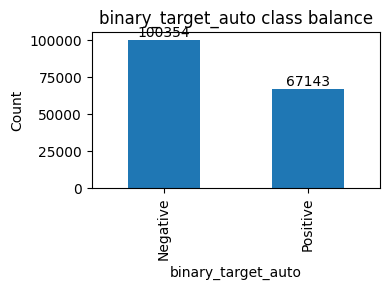

In [89]:
#class balance
fig, ax = plt.subplots(figsize=(4,3))
(y.value_counts().sort_index()
   .rename(index={0:"Negative", 1:"Positive"})
   .plot(kind="bar", ax=ax))
ax.set_title(f"{TARGET} class balance")
ax.set_ylabel("Count")
ax.bar_label(ax.containers[0])
plt.tight_layout(); plt.show()

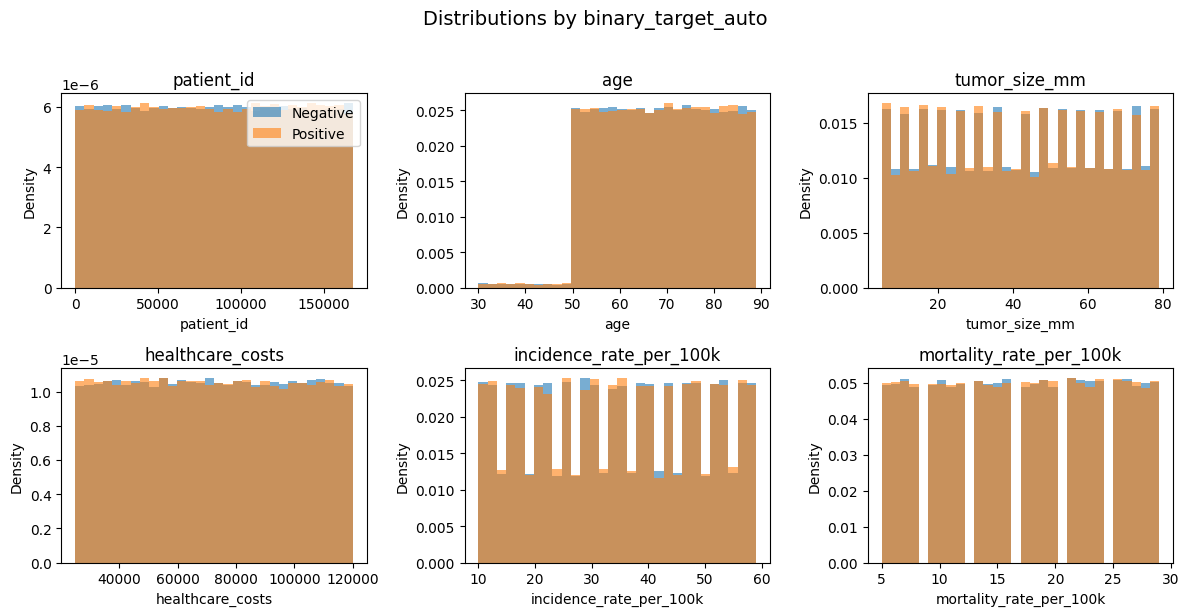

In [90]:
#grids for key labs/biomarkers by outcome
K = 8  # how many numeric cols to show
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET in num_cols: num_cols.remove(TARGET)
cols = num_cols[:K]

n = len(cols); ncols = 3; nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(df.loc[y==0, col].dropna(), bins=30, density=True, alpha=0.6, label="Negative")
    ax.hist(df.loc[y==1, col].dropna(), bins=30, density=True, alpha=0.6, label="Positive")
    ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Density")
    if i == 0: ax.legend()

for j in range(i+1, len(axes)): axes[j].axis("off")
plt.suptitle(f"Distributions by {TARGET}", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

/tmp/ipykernel_3413/2558059698.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
/tmp/ipykernel_3413/2558059698.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
/tmp/ipykernel_3413/2558059698.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
/tmp/ipykernel_3413/2558059698.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since M

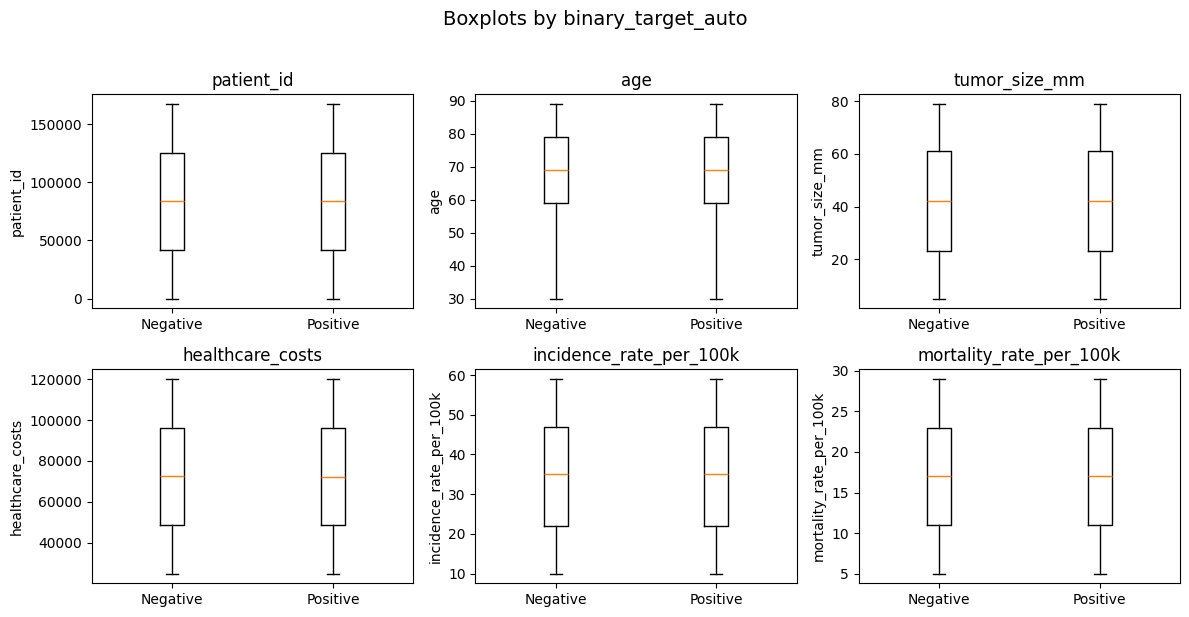

In [91]:
#grid of boxplots (same features)

n = len(cols); ncols = 3; nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    data0 = df.loc[y==0, col].dropna()
    data1 = df.loc[y==1, col].dropna()
    ax.boxplot([data0, data1], labels=["Negative","Positive"], showfliers=False)
    ax.set_title(col); ax.set_ylabel(col)

for j in range(i+1, len(axes)): axes[j].axis("off")
plt.suptitle(f"Boxplots by {TARGET}", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

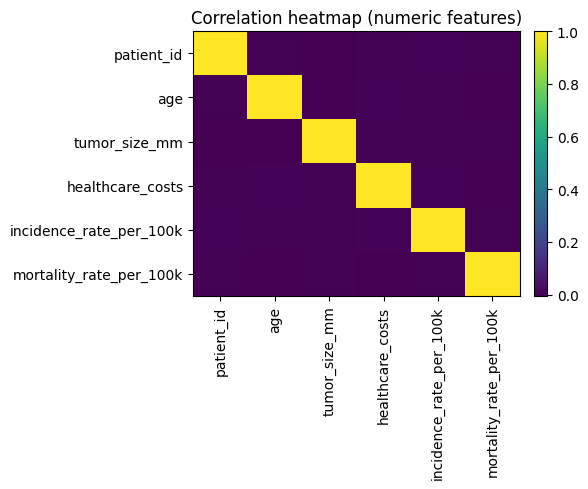

In [92]:
#correlation heatmap (numeric features)

num = df[safe_numeric_cols(df)].copy()
if TARGET in num.columns: num = num.drop(columns=[TARGET])
if not num.empty:
    corr = num.corr()
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticks(range(len(corr.columns))); ax.set_yticklabels(corr.columns)
    ax.set_title("Correlation heatmap (numeric features)")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

/tmp/ipykernel_3413/184089803.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby(grp)[TARGET].mean()


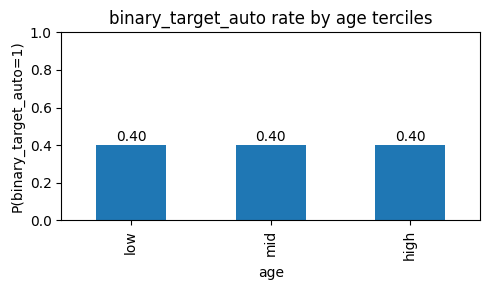

In [93]:
#simple clinical stratification (terciles)
candidates = [c for c in ["age","bmi","hemoglobin","hematocrit","wbc","glucose","albumin","crp","cea"] if c in df.columns]
if not candidates:
    candidates = safe_numeric_cols(df)[:3]

for col in candidates:
    s = df[col].dropna()
    if s.empty: 
        continue
    q = s.quantile([0.33, 0.67]).values
    bins = [-np.inf, q[0], q[1], np.inf]
    labels = ["low","mid","high"]
    grp = pd.cut(df[col], bins=bins, labels=labels)
    rates = df.groupby(grp)[TARGET].mean()
    fig, ax = plt.subplots(figsize=(5,3))
    rates.plot(kind="bar", ax=ax)
    ax.set_ylim(0,1); ax.set_ylabel(f"P({TARGET}=1)")
    ax.set_title(f"{TARGET} rate by {col} terciles")
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.02, f"{p.get_height():.2f}", ha="center")
    plt.tight_layout(); plt.show()

Week 4 — Logistic Regression + Feature Scaling (Colorectal)
Objective

Build and evaluate a logistic regression classifier (with proper feature scaling and one-hot encoding) on the colorectal_cancer_dataset.csv. Report stratified 5-fold CV and a 30% holdout using Accuracy, ROC-AUC, Precision, Recall, and F1. Interpret the most influential features.

Target (how it was chosen)

Use any clear 0/1 status column (e.g., survival_status, death_event, mort_90_day, recurrence, …), including yes/no / true/false mapping.

If none, derive advanced stage from a stage column (III/IV → 1; I/II → 0).

If none, derive short_survival from survival_months via median split.

If still none, median-split the highest-variance numeric column.
→ The chosen target is stored as binary_target_auto and the console prints:
Binary target created: binary_target_auto ← <rule/details>

If you must lock a specific label, set FORCE_TARGET = "your_column" near the top.

Features & Preprocessing

Numeric features: impute 0.0 → StandardScaler.

Categorical features: fill "__missing__" → One-Hot Encoder (handle_unknown="ignore").

Leakage prevention: if the label was derived from stage or survival_months (or any source column), that source is dropped from X.

Pipeline:
ColumnTransformer([scale numerics, OHE categoricals]) → LogisticRegression(lbfgs, max_iter=5000, class_weight="balanced" if minority < 35%)

Validation Protocol

Stratified 5-fold CV (keeps class distribution per fold) with metrics:

Accuracy, ROC-AUC, Precision, Recall, F1 (macro-style positive class focus).

Shared 30% holdout for an apples-to-apples test after CV.

Threshold fixed at 0.50 for holdout classification; ROC-AUC uses probabilities.

Interpretability (Top Coefficients)

The script prints Top 20 features by |coefficient| (in the standardized/OHE space).

Positive coef → increases log-odds of the positive class; negative → decreases.

Since numerics are scaled, magnitudes across numeric features are comparable; OHE dummies are 0/1.

Paste a few highlights here:
• feature_A (+): higher odds of positive outcome.
• feature_B (−): lower odds of positive outcome.
• stage_* dummies (if present) and key labs/vitals often rank highly.

Third Dataset: Diabetes

In [94]:
POSSIBLE_PATHS = [
    "/mnt/data/diabetes_012_health_indicators_BRFSS2015.csv",
    "diabetes_012_health_indicators_BRFSS2015.csv",
]
# If True → label = 1 only for Diabetes (2); if False → label = 1 for Prediabetes(1) or Diabetes(2)
DIABETES_ONLY = False     # change to True if you want 2 vs (0/1)
FORCE_TARGET = None       # e.g., "diabetes_binary" if you already have a 0/1 column

In [95]:
import os
# Load & tidy
for p in POSSIBLE_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break
else:
    DATA_PATH = POSSIBLE_PATHS[0]  # will raise if missing

df = pd.read_csv(DATA_PATH, low_memory=True)

# normalize column names
df.columns = (df.columns.astype(str)
              .str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
              .str.lower())

In [96]:
#  Binary target selection/derivation
def coerce_binary_series(s: pd.Series):
    """Accepts 0/1 ints or maps common boolean-ish strings to 0/1. Return None if not clean binary."""
    # numeric 0/1?
    try_num = pd.to_numeric(s, errors="coerce")
    if try_num.dropna().isin([0,1]).all() and try_num.dropna().nunique() == 2:
        return try_num.astype(int)

    # string yes/no/true/false mapping
    m = s.astype(str).str.strip().str.lower()
    mapping = {"yes":1,"y":1,"true":1,"t":1,"1":1,"pos":1,"positive":1,
               "no":0,"n":0,"false":0,"f":0,"0":0,"neg":0,"negative":0}
    mapped = m.map(mapping)
    if mapped.dropna().nunique() == 2 and set(mapped.dropna().unique()) <= {0,1}:
        return mapped.astype(int)

    return None

bin_target = None
source_cols_to_drop = []

if FORCE_TARGET is not None and FORCE_TARGET in df.columns:
    y_tmp = coerce_binary_series(df[FORCE_TARGET])
    if y_tmp is None:
        raise ValueError(f"FORCE_TARGET='{FORCE_TARGET}' is not binary/boolean-mappable.")
    y = y_tmp.astype(int)
    bin_target = f"{FORCE_TARGET} (forced)"
else:
    # 1) If 'diabetes_binary' exists and is clean 0/1, use it
    if "diabetes_binary" in df.columns:
        y_tmp = coerce_binary_series(df["diabetes_binary"])
        if y_tmp is not None:
            y = y_tmp.astype(int)
            bin_target = "diabetes_binary"

    # 2) Else derive from 'diabetes_012' if present
    if bin_target is None and "diabetes_012" in df.columns:
        d012 = pd.to_numeric(df["diabetes_012"], errors="coerce")
        if DIABETES_ONLY:
            # 2 vs (0/1)
            y = (d012 == 2).astype(int)
            bin_target = "diabetes_only (2 vs 0/1) from diabetes_012"
        else:
            # 1/2 vs 0
            y = (d012 >= 1).astype(int)
            bin_target = "prediabetes_or_diabetes (1/2 vs 0) from diabetes_012"
        source_cols_to_drop.append("diabetes_012")

# If still none, try to find any clean 0/1 column named like diabetes
if bin_target is None:
    for c in df.columns:
        if "diab" in c:
            y_tmp = coerce_binary_series(df[c])
            if y_tmp is not None:
                y = y_tmp.astype(int)
                bin_target = f"{c} (auto)"
                break

if bin_target is None:
    raise ValueError("No suitable binary target found or derivable. "
                     "Set FORCE_TARGET to a 0/1 column or ensure diabetes_012/diabetes_binary is present.")

print(f"Binary target: {bin_target}")
pos_rate = float(y.mean())
print(f"Positive rate: {pos_rate:.3f}")

# Keep only rows with non-missing y
mask = ~y.isna()
y = y.loc[mask].reset_index(drop=True)
df = df.loc[mask].reset_index(drop=True)


Binary target: prediabetes_or_diabetes (1/2 vs 0) from diabetes_012
Positive rate: 0.158


In [97]:
# Features: numeric vs categorical
X = df.drop(columns=source_cols_to_drop, errors="ignore")  # drop diabetes_012 if used
# Also drop the target column itself if it exists in X
for c in ["diabetes_binary"]:
    X = X.drop(columns=[c], errors="ignore")

num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

# Quick NA handling (leave scaling/encoding to the pipeline)
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0.0).astype("float32")
for c in cat_cols:
    X[c] = X[c].astype("category").cat.add_categories(["__missing__"]).fillna("__missing__")

In [98]:
#  Preprocessor (Scaling + OHE)
# Handle both modern and older sklearns for OHE arg name
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

In [99]:
#  Model (handle imbalance if needed)
use_balanced = (min(pos_rate, 1 - pos_rate) < 0.35)
log_reg = LogisticRegression(
    max_iter=5000,
    solver="lbfgs",
    class_weight="balanced" if use_balanced else None
)
pipe = Pipeline(steps=[("pre", pre), ("clf", log_reg)])
print(f"class_weight: {'balanced' if use_balanced else 'None'}")

class_weight: balanced


In [100]:
# Stratified 5-fold CV 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipe, X, y, cv=cv,
    scoring={
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
    },
    n_jobs=-1, return_estimator=False
)

def pm(m): return f"{np.mean(m):.4f} ± {np.std(m):.4f}"

cv_table = pd.DataFrame({
    "Metric": ["Accuracy", "ROC-AUC", "Precision", "Recall", "F1"],
    "5-fold CV (mean ± std)": [
        pm(scores["test_accuracy"]),
        pm(scores["test_roc_auc"]),
        pm(scores["test_precision"]),
        pm(scores["test_recall"]),
        pm(scores["test_f1"]),
    ],
})
print("\n=== Week 4 — Logistic Regression with Scaling (Stratified 5-fold CV) ===")
print(cv_table.to_string(index=False))


=== Week 4 — Logistic Regression with Scaling (Stratified 5-fold CV) ===
   Metric 5-fold CV (mean ± std)
 Accuracy        0.7292 ± 0.0017
  ROC-AUC        0.8177 ± 0.0015
Precision        0.3397 ± 0.0019
   Recall        0.7609 ± 0.0026
       F1        0.4697 ± 0.0023


In [101]:
# 30% Holdout
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

pipe.fit(X_tr, y_tr)
probs = pipe.predict_proba(X_te)[:, 1]
pred  = (probs >= 0.5).astype(int)

hold = {
    "Accuracy":  accuracy_score(y_te, pred),
    "ROC-AUC":   roc_auc_score(y_te, probs),
    "Precision": precision_score(y_te, pred, zero_division=0),
    "Recall":    recall_score(y_te, pred, zero_division=0),
    "F1":        f1_score(y_te, pred, zero_division=0),
}
hold_table = pd.DataFrame([hold])
print("\n=== Week 4 — 30% Holdout (threshold=0.5) ===")
print(hold_table.to_string(index=False))

print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(confusion_matrix(y_te, pred), index=["0","1"], columns=["0","1"]))

print("\nClassification report:")
print(classification_report(y_te, pred, digits=4, zero_division=0))


=== Week 4 — 30% Holdout (threshold=0.5) ===
 Accuracy  ROC-AUC  Precision   Recall       F1
 0.729699 0.817294    0.34038 0.762612 0.470679

Confusion matrix (rows=true, cols=pred):
       0      1
0  46387  17724
1   2847   9146

Classification report:
              precision    recall  f1-score   support

           0     0.9422    0.7235    0.8185     64111
           1     0.3404    0.7626    0.4707     11993

    accuracy                         0.7297     76104
   macro avg     0.6413    0.7431    0.6446     76104
weighted avg     0.8473    0.7297    0.7637     76104



In [102]:
# Top coefficients (interpretability)
# Refit on all data to list the largest-magnitude coefficients
pipe.fit(X, y)

# Recover feature names from the preprocessor
num_names = list(num_cols)
try:
    cat_names = list(pipe.named_steps["pre"].named_transformers_["cat"].get_feature_names_out(cat_cols)) if len(cat_cols) else []
except Exception:
    cat_names = []
feat_names = np.array(num_names + cat_names, dtype=object)

coefs = pipe.named_steps["clf"].coef_.ravel()
order = np.argsort(np.abs(coefs))[::-1]
k = min(20, len(order))
top = pd.DataFrame({
    "feature": feat_names[order][:k],
    "coef": coefs[order][:k],
    "abs_coef": np.abs(coefs[order][:k])
})
print("\nTop coefficients by |magnitude| (standardized/OHE space):")
print(top.to_string(index=False))


Top coefficients by |magnitude| (standardized/OHE space):
             feature      coef  abs_coef
             genhlth  0.587020  0.587020
                 bmi  0.484859  0.484859
                 age  0.457165  0.457165
              highbp  0.340495  0.340495
            highchol  0.294048  0.294048
           cholcheck  0.231553  0.231553
   hvyalcoholconsump -0.148657  0.148657
              income -0.129141  0.129141
                 sex  0.127098  0.127098
heartdiseaseorattack  0.065079  0.065079
            physhlth -0.057793  0.057793
           education -0.044296  0.044296
            diffwalk  0.030459  0.030459
         nodocbccost  0.029762  0.029762
              stroke  0.027140  0.027140
              fruits -0.023599  0.023599
        physactivity -0.018660  0.018660
            menthlth -0.018013  0.018013
             veggies -0.016170  0.016170
       anyhealthcare  0.010144  0.010144


In [103]:
# ---- assumptions ----
# df: full dataframe with features + target
# X, y: features/target
# X_tr, X_te, y_tr, y_te: train/test split
# pipe: fitted or fit-able sklearn Pipeline (pre + clf)
TARGET = y.name if isinstance(y, pd.Series) else "Diabetes_012"

def safe_numeric_cols(frame):
    return frame.select_dtypes(include=np.number).columns.tolist()

def safe_categorical_cols(frame, max_card=20):
    cats = frame.select_dtypes(exclude=np.number).columns.tolist()
    # also treat {0,1} integer/bool as categorical
    for c in frame.columns:
        if pd.api.types.is_integer_dtype(frame[c]) or pd.api.types.is_bool_dtype(frame[c]):
            if frame[c].nunique() <= max_card and c not in cats:
                cats.append(c)
    # do not include the target
    return [c for c in cats if c != TARGET]

def get_feature_names(preprocessor, X_fit):
    try:
        return preprocessor.get_feature_names_out()
    except Exception:
        names = []
        for name, trans, cols in getattr(preprocessor, "transformers_", []):
            if name == "remainder" and trans == "drop":
                continue
            if hasattr(trans, "get_feature_names_out"):
                names.extend(trans.get_feature_names_out(cols))
            else:
                names.extend(list(cols))
        return np.array([str(n) for n in names])

def top_k_abs(series, k=20):
    idx = np.argsort(np.abs(series.values))[::-1][:k]
    return series.iloc[idx]

def is_multiclass(y_like):
    return pd.Series(y_like).nunique() > 2

# choose a "positive" class for ROC/PR (prefer class 2 if present; else max; else 1)
def pick_positive_label(y_like):
    uniq = sorted(pd.Series(y_like).unique())
    return 2 if 2 in uniq else (1 if 1 in uniq else uniq[-1])

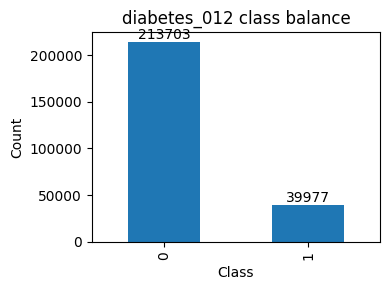

In [104]:
#outcome distribution (handles binary or tri-class)
fig, ax = plt.subplots(figsize=(4,3))
vc = y.value_counts().sort_index()
vc.plot(kind="bar", ax=ax)
ax.set_title(f"{TARGET} class balance")
ax.set_xlabel("Class"); ax.set_ylabel("Count")
ax.bar_label(ax.containers[0])
plt.tight_layout(); plt.show()

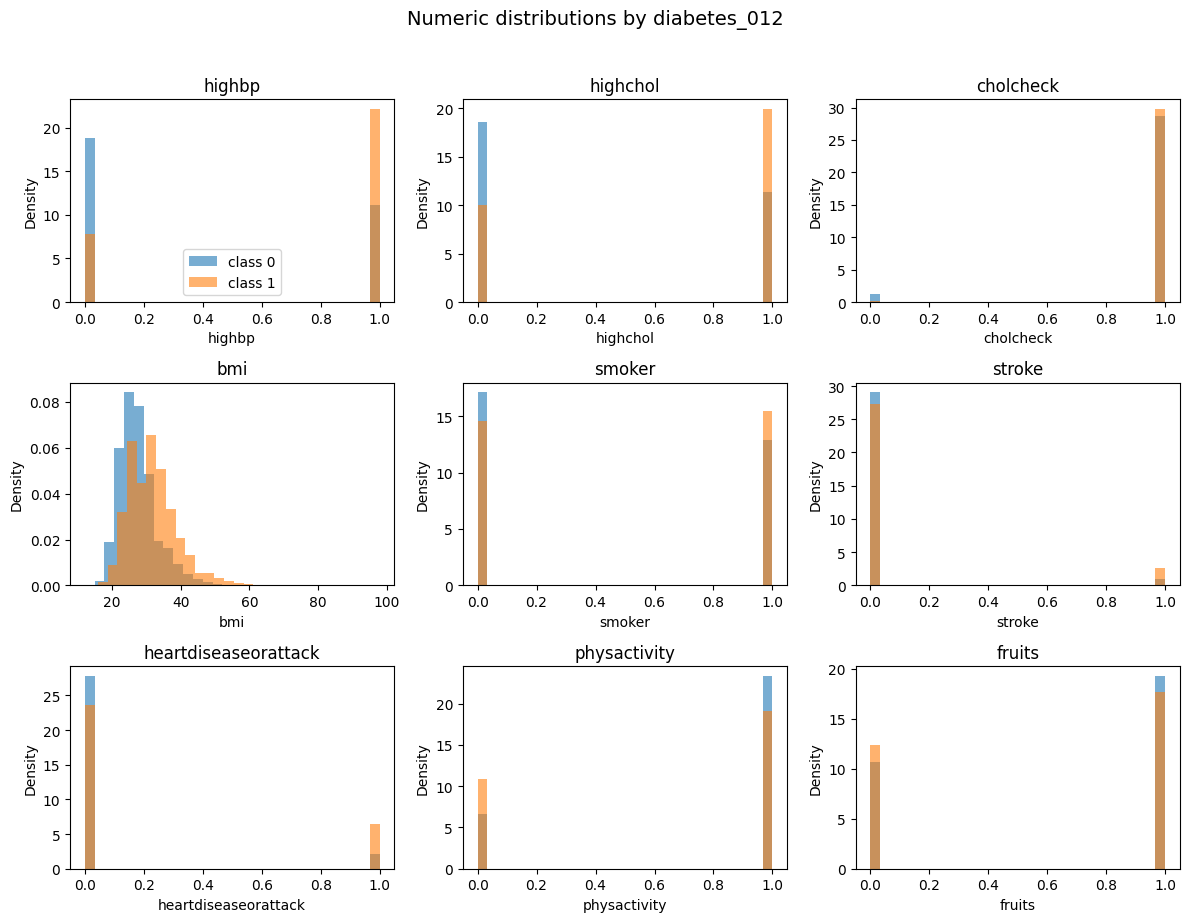

In [105]:
#key feature distributions by class
# pick up to K numeric features (drop target if numeric)
K = 9
num_cols = safe_numeric_cols(df)
if TARGET in num_cols: num_cols.remove(TARGET)
cols = num_cols[:K]

n = len(cols); ncols = 3; nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = np.atleast_1d(axes).ravel()

classes = sorted(y.unique())
for i, col in enumerate(cols):
    ax = axes[i]
    for cls in classes:
        ax.hist(df.loc[y==cls, col].dropna(), bins=30, density=True, alpha=0.6, label=f"class {cls}")
    ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Density")
    if i == 0: ax.legend()

for j in range(i+1, len(axes)): axes[j].axis("off")
plt.suptitle(f"Numeric distributions by {TARGET}", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

In [106]:
#categorical prevalence heatmap
cat_cols = [c for c in safe_categorical_cols(df) if c in df.columns and df[c].nunique()<=10][:12]  # cap to 12
if cat_cols:
    # compute prevalence (mean of 1s or mode-share) per class
    classes = sorted(y.unique())
    mat = []
    for c in cat_cols:
        row = []
        for cls in classes:
            s = df.loc[y==cls, c]
            if pd.api.types.is_numeric_dtype(s) and s.nunique()<=10:
                # assume 0/1 or small ordinal; show mean (interpretable as prevalence if binary)
                row.append(float(s.mean()))
            else:
                # fallback: proportion of the most frequent category
                row.append(s.value_counts(normalize=True).head(1).iloc[0] if not s.empty else np.nan)
        mat.append(row)
    mat = np.array(mat)

    fig, ax = plt.subplots(figsize=(1.2+1.2*len(classes), 0.5+0.45*len(cat_cols)))
    im = ax.imshow(mat, aspect="auto")
    ax.set_yticks(range(len(cat_cols))); ax.set_yticklabels(cat_cols)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels([f"class {c}" for c in classes], rotation=0)
    ax.set_title("Categorical prevalence by class")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

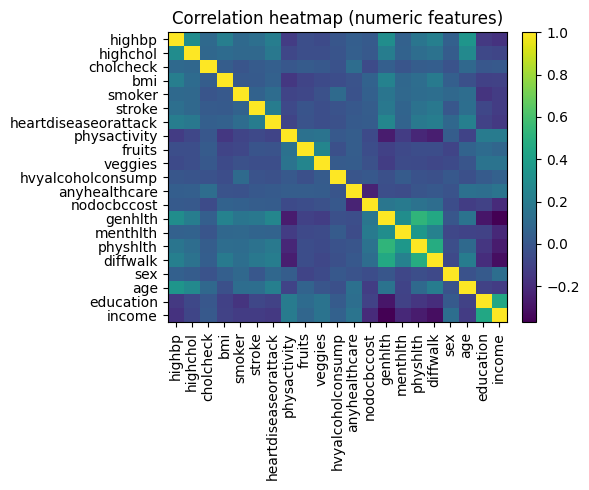

In [107]:
#correlation heatmap (numeric only, excludes target if numeric)

num = df[safe_numeric_cols(df)].copy()
if TARGET in num.columns: num = num.drop(columns=[TARGET])
if not num.empty:
    corr = num.corr()
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(corr.values, aspect="auto")
    ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticks(range(len(corr.columns))); ax.set_yticklabels(corr.columns)
    ax.set_title("Correlation heatmap (numeric features)")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

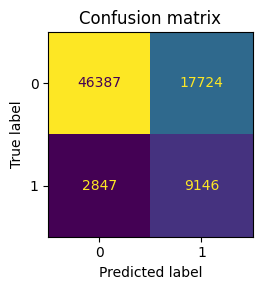

<Figure size 400x300 with 0 Axes>

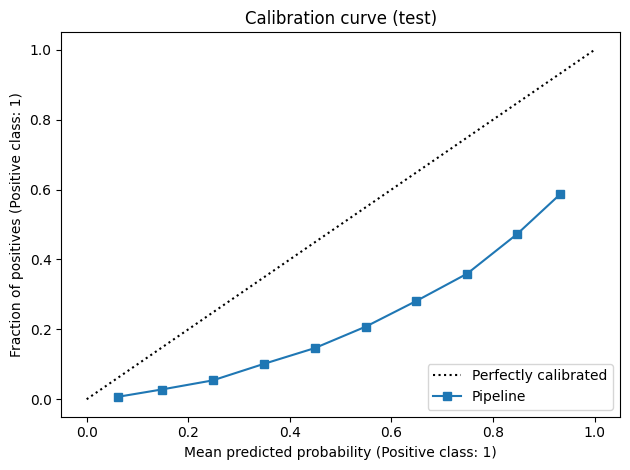

<Figure size 400x300 with 0 Axes>

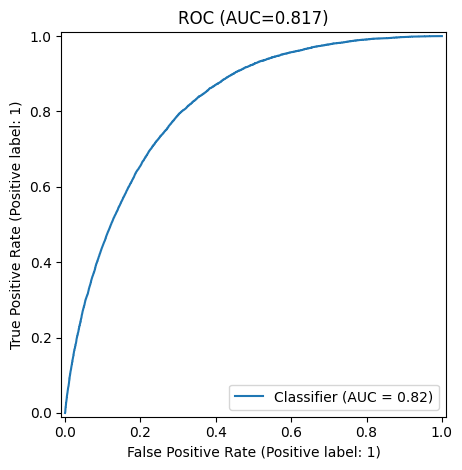

<Figure size 400x300 with 0 Axes>

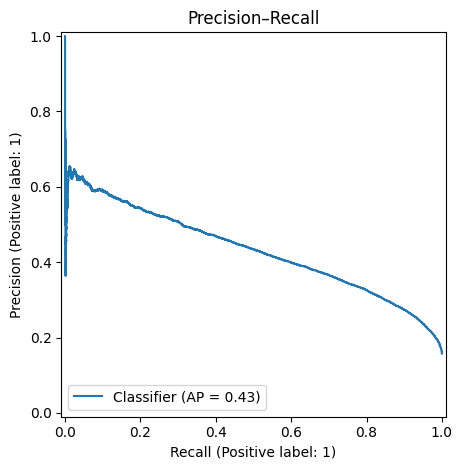

In [108]:
#model curves: ROC, PR (binary or one-vs-rest for class “2” if tri-class), confusion matrix, calibration
# fit if needed
pipe.fit(X_tr, y_tr)
proba_te = pipe.predict_proba(X_te)
pred_te  = pipe.predict(X_te)

# Confusion matrix (works for multi-class)
cm = confusion_matrix(y_te, pred_te)
fig, ax = plt.subplots(figsize=(4,3))
ConfusionMatrixDisplay(cm).plot(values_format="d", ax=ax, colorbar=False)
ax.set_title("Confusion matrix")
plt.tight_layout(); plt.show()

# Calibration (binary only)
if not is_multiclass(y_te):
    fig = plt.figure(figsize=(4,3))
    CalibrationDisplay.from_estimator(pipe, X_te, y_te, n_bins=10, strategy="uniform")
    plt.title("Calibration curve (test)")
    plt.tight_layout(); plt.show()

# ROC / PR
if is_multiclass(y_te):
    # pick a positive class for one-vs-rest curves (prefer class 2 if present)
    pos_label = pick_positive_label(y_te)
    y_bin = (y_te == pos_label).astype(int)
    # find column matching pos_label (LogReg in sklearn outputs probs in class order)
    classes = pipe.named_steps.get("clf", None).classes_ if "clf" in pipe.named_steps else np.unique(y_tr)
    pos_idx = list(classes).index(pos_label)
    pos_proba = proba_te[:, pos_idx]

    fig = plt.figure(figsize=(4,3))
    RocCurveDisplay.from_predictions(y_bin, pos_proba)
    plt.title(f"ROC (one-vs-rest for class {pos_label})")
    plt.tight_layout(); plt.show()

    fig = plt.figure(figsize=(4,3))
    PrecisionRecallDisplay.from_predictions(y_bin, pos_proba)
    plt.title(f"Precision–Recall (one-vs-rest for class {pos_label})")
    plt.tight_layout(); plt.show()
else:
    # binary: take positive class probability column 1
    pos_proba = proba_te[:, 1] if proba_te.ndim == 2 else proba_te
    fig = plt.figure(figsize=(4,3))
    RocCurveDisplay.from_predictions(y_te, pos_proba)
    plt.title(f"ROC (AUC={roc_auc_score(y_te, pos_proba):.3f})")
    plt.tight_layout(); plt.show()

    fig = plt.figure(figsize=(4,3))
    PrecisionRecallDisplay.from_predictions(y_te, pos_proba)
    plt.title("Precision–Recall")
    plt.tight_layout(); plt.show()

Week 4 — Logistic Regression + Feature Scaling (Diabetes BRFSS2015)
Objective

Train and evaluate a logistic regression classifier (with proper feature scaling and one-hot encoding) to predict diabetes status from the BRFSS 2015 health indicators dataset. Report stratified 5-fold CV and a 30% holdout using Accuracy, ROC-AUC, Precision, Recall, and F1. Interpret the most influential features.


If diabetes_binary exists, used directly; else derived from diabetes_012 as:

Default: Prediabetes or Diabetes (1/2) vs No (0)

Optional: Diabetes only (2) vs (0/1) if DIABETES_ONLY=True


Preprocessing

Column cleanup: lowercased, spaces/symbols → underscores.

Numeric: imputed with 0.0, then StandardScaler.

Categorical: __missing__ placeholder then One-Hot Encoder (handle_unknown="ignore").

Pipeline: ColumnTransformer([scale numerics, OHE categoricals]) → LogisticRegression(lbfgs, max_iter=5000, class_weight="balanced" if minority < 35%)

Split: 70/30 stratified train/holdout.


Operating point: At threshold 0.50. If public-health screening is the goal, consider increasing Recall (lower threshold) at the cost of Precision.
